In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

In [7]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=2e-4)
parser.add_argument("--nch_g", type=int, default=128)
parser.add_argument("--nch_d", type=int, default=128)
parser.add_argument("--z_dim", type=int, default=100) # noize dimension
parser.add_argument("--beta1", type=float, default=0.5) # for Adam optimizer
opt = parser.parse_args(args=[])

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100+10, ngf=128, nc=1):   # nc=1 for black-and-white images
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4*ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4*ngf, 2*ngf, 3, 2, 0)
        self.convt3 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                               stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out


In [ ]:
x = torch.randn([32, 100, 1, 1])
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g)
out = netG(x)

In [ ]:
out.size()

torch.Size([32, 1, 28, 28])

In [4]:
class Discriminator(nn.Module):
    def __init__(self, nc=1+10, ndf=128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm=False)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(4*ndf, 1, 3, 1, 0),
            nn.Sigmoid()
        )

    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=2,
                    has_batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                      padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out


In [8]:
x = torch.randn(32, 1, 28, 28)
netD = Discriminator(nc=1, ndf=opt.nch_d)
out = netD(x)

In [9]:
out.size()

torch.Size([32, 1, 1, 1])

In [10]:
def weights_init(m):
    # m means model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)   # initialize using normal distribution
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   # initialize using normal distribution
        nn.init.constant_(m.bias.data, 0)   # initialize


In [11]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [12]:
import os

In [13]:
dir_path = "/content/drive/MyDrive/result"
os.makedirs(dir_path, exist_ok=True)

In [14]:
dataset = dset.MNIST(root="/content/drive/MyDrive/data/", download=False,
                     train=True, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# One-hot-vector の次元 10 を足す（10種類の分類）
netG = Generator(z_dim=opt.z_dim+10, ngf=opt.nch_g).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc=1+10, ndf=opt.nch_d).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(11, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope

In [17]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999), weight_decay=1e-5)

In [18]:
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth".format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch)
    )


In [19]:
model_name = "ConditionalDCGAN"
f_path_result = "/content/drive/MyDrive/result/{}".format(model_name)
f_path_params = "/content/drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

In [21]:
def get_noise_with_label(noise, labels, device, n_class=10):
    one_hot_vec = torch.nn.functional.one_hot(labels, num_classes=n_class).view(-1, n_class, 1, 1).to(device)   # noise が GPU 上にあるため
    concat_noise = torch.cat((noise, one_hot_vec), dim=1)   # channel 方向にノイズをくっつける
    return concat_noise

def get_img_with_label(imgs, labels, device, n_class=10):
    B, _, H, W = imgs.size()
    one_hot_vec = torch.nn.functional.one_hot(labels, num_classes=n_class).view(-1, n_class, 1, 1)
    one_hot_vec = one_hot_vec.expand(B, n_class, H, W).to(device)
    concat_imgs = torch.cat((imgs, one_hot_vec), dim=1)   # channel 方向にノイズをくっつける
    return concat_imgs

In [20]:
torch.nn.functional.one_hot(torch.tensor([1]), num_classes=10)

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

100%|██████████| 938/938 [00:35<00:00, 26.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: 0.6579118018735574, lossG: 2.7309905845346227


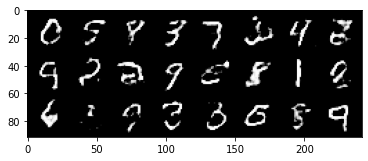

100%|██████████| 938/938 [00:35<00:00, 26.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: 1.0712516985214087, lossG: 1.526178069841633


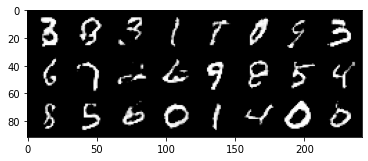

100%|██████████| 938/938 [00:34<00:00, 26.90it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, lossD: 1.096389543400136, lossG: 1.4394063325261257


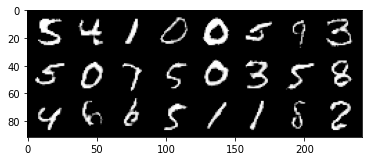

100%|██████████| 938/938 [00:34<00:00, 26.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, lossD: 1.0680759986326385, lossG: 1.4542159132166965


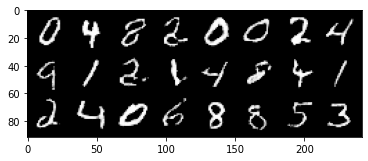

100%|██████████| 938/938 [00:34<00:00, 26.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, lossD: 1.046562123718038, lossG: 1.5113908371437332


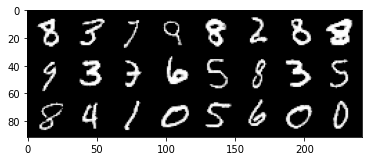

100%|██████████| 938/938 [00:34<00:00, 26.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, lossD: 1.024043836636838, lossG: 1.562698259441329


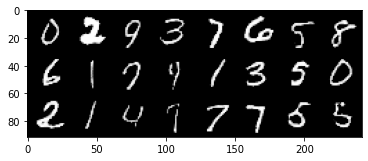

100%|██████████| 938/938 [00:34<00:00, 26.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, lossD: 0.9855015994643351, lossG: 1.632700232967639


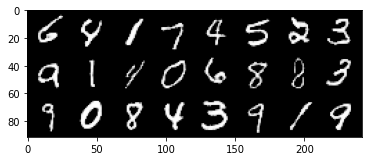

100%|██████████| 938/938 [00:34<00:00, 26.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, lossD: 0.9620583436763617, lossG: 1.6871143798711203


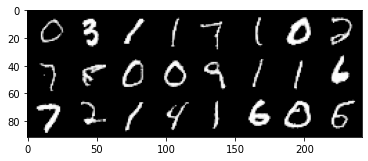

100%|██████████| 938/938 [00:34<00:00, 26.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, lossD: 0.9099944808653423, lossG: 1.8041873562818906


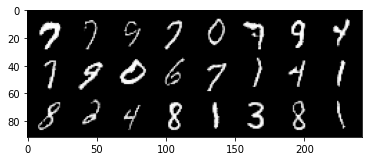

100%|██████████| 938/938 [00:35<00:00, 26.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, lossD: 0.8761329457703938, lossG: 1.8877443973697834


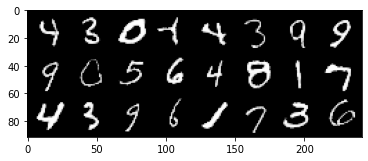

In [22]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []

for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position=0)):
        real_imgs = real_imgs.to(device)    # GPU 上に写真を送る
        real_imgs_with_label = get_img_with_label(real_imgs, labels, device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)
        noise_with_label = get_noise_with_label(noise, labels, device)

        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)
        #
        # Train Disc
        #
        netD.zero_grad()
        output = netD(real_imgs_with_label)
        lossD_real = criterion(output, labels_real)

        fake_imgs = netG(noise_with_label)
        fake_imgs_with_label = get_img_with_label(fake_imgs, labels, device)
        output = netD(fake_imgs_with_label.detach())   # 識別器の訓練の際には、生成器の方は更新しないので、detach
        lossD_fake = criterion(output, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        #
        # Train Gen
        #
        netG.zero_grad()
        output = netD(fake_imgs_with_label)
        lossG = criterion(output, labels_real)  # real を渡すのがポイント、生成器は騙したいので！fakeが真
        lossG.backward()
        optimizerG.step()

        #
        # save losses
        #
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())
    
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print("epoch: {}, lossD: {}, lossG: {}".format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))
    plt.show()

    # save imgs and params
    vutils.save_image(fake_imgs, f_path_result + "/{:04d}.jpg".format(epoch))
    save_params(f_path_params, epoch, netD, netG)


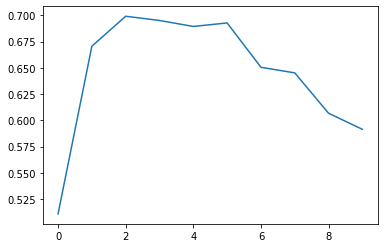

In [ ]:
plt.plot(lossesD)

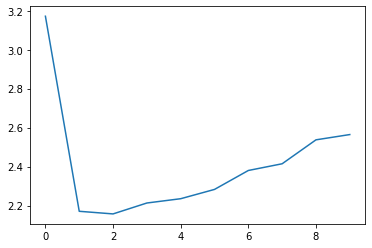

In [ ]:
plt.plot(lossesG)

In [23]:
netG.eval()

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

In [32]:
number = 3
noise = torch.randn([1, opt.z_dim, 1, 1]).to(device)
labels = torch.tensor([number]).to(device)
noise_with_label = get_noise_with_label(noise, labels, device)

In [33]:
out = netG(noise_with_label)

In [34]:
out.size()

torch.Size([1, 1, 28, 28])

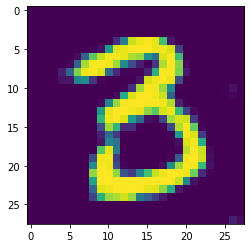

In [35]:
plt.imshow(out.squeeze_().detach().cpu().numpy())        # squeeze_ をつけると、inplace の意味（置き換える）